In [6]:
#coding: utf-8

import warnings
warnings.simplefilter("ignore")

import os
import sys 
import wave
import time
import pickle
from scipy.io.wavfile import read
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from StringIO import StringIO

%pylab inline

# sudo pip install librosa
# ubuntu: sudo apt-get install libav-tools
# OSX   : brew install libav OMP_NUM_THREADS=2

Populating the interactive namespace from numpy and matplotlib


# Get the Data

Датасет для контеста помещен вот здесь: https://yadi.sk/d/3jmeVCfSwTKgm (внимание! файл весит 3,5 Гб)


Он распаковывается в папку "musicdata". Все пути в этом ноутбуке будут относительно этой папки: "./musicdata/\*". 

Вы можете изменить базовый путь, как вам удобно.

In [7]:
BP = "../../musicdata/"

# Just a Sound

Для начала попробуем поработать со звуком - послушайте любой трек, постройте график сырых данных и спектрограмму.

In [8]:
import IPython
from IPython import display

def Audio(url):
    return display.HTML("<center><audio controls><source src='{}' type=\"audio/wav\"></audio>".format(url))

In [9]:
sound_file = os.path.join(BP, "audiosamples", "short_206377.wav")
#sound_file = "./short_206377.wav"
rate, signal = read(sound_file)

Audio(url=sound_file)

# Sound as 1D-Signal

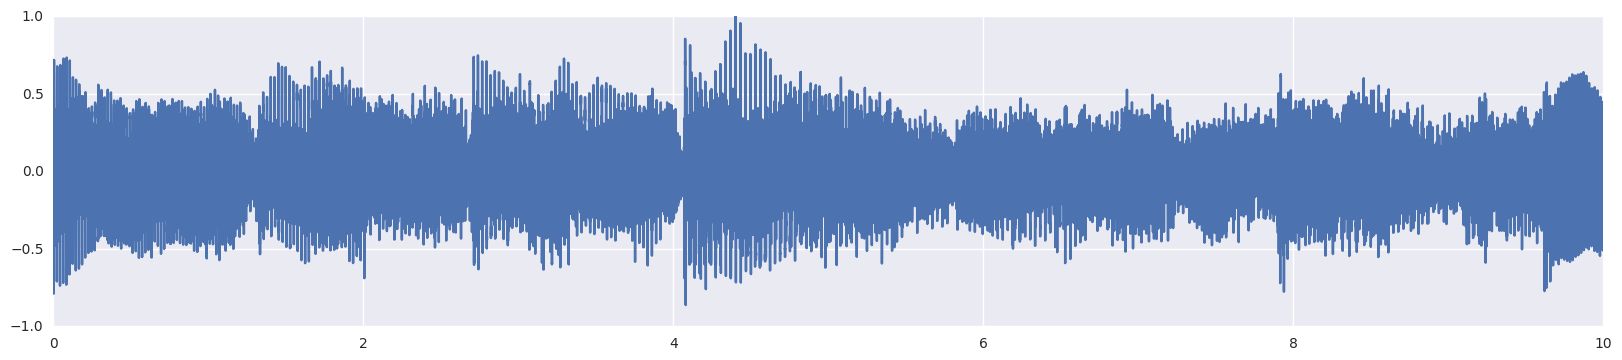

In [10]:
plt.figure(figsize=(20,4))
time = np.linspace(0, len(signal) / rate, len(signal))
plt.plot(time, signal)
plt.show()


# Sound as 2D-Signal

Нашу цель слелать из предыдущего графика картинку - для этого нам нужно оценить частоты в каждый момент времени. Благо за нас это умеет делать librosa, у которой внутри STFFT. Используйте librosa.feature.melspectrogram -- для получения спектрограммы, и librosa.logamplitude для выравнивания диапазонов частот. 

help: https://gist.github.com/mailletf/3484932dd29d62b36092

In [11]:
data = []
for i in range(1, 8):
    path = os.path.join(BP, "spectrograms/spectrograms{}.pcl".format(i))
    with open(path, "rb") as fin:
        data.extend(list(np.load(fin)))
data = np.array(data)

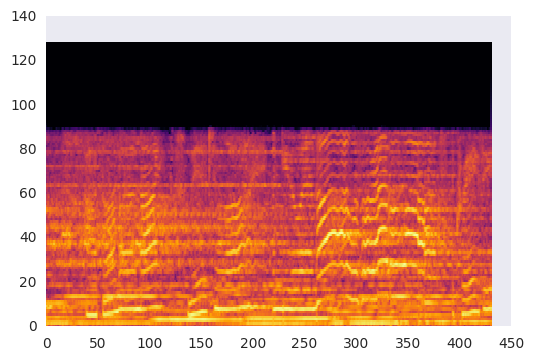

In [12]:
plt.pcolormesh(data[103], cmap='inferno')

In [13]:
with open(os.path.join(BP, "train_genres.txt"), "r") as fin:
    genres = fin.read().splitlines()

In [14]:
print("ALL GENRES\n")
print("\n".join(np.unique(genres)))
print("\nTotal: {}".format(len(np.unique(genres))))

ALL GENRES

african
alternative
amerfolk
asiapop
balkan
bard
blues
bollywood
celtic
children
classical
conjazz
country
dance
disco
dnb
dub
dubstep
eastern
electronics
estrada
eurofolk
experimental
folk
funk
hardcore
holiday
house
indie
industrial
jazz
jewish
latinfolk
lounge
meditation
metal
modern
musical
newage
newwave
other
pop
prog
punk
rap
reggae
reggaeton
relax
rnb
rnr
rock
rusfolk
rusrap
rusrock
shanson
ska
soul
soundtrack
spiritual
spoken
sport
techno
tradjazz
trance
ukrrock
urban
vocal

Total: 67


In [15]:
from collections import defaultdict
X = data[:12000]
X_kaggle = data[12000:]
mapping = defaultdict(lambda: len(mapping))
y = np.array(list(map(lambda x: mapping[x], genres)))
inv_mapping = dict(zip(mapping.values(), mapping.keys()))

# Nearest Neighbors genre classification

Перемешаем датасет - используйте `np.random.permutation` и индексацию `a[np.random.permutation]`.

In [16]:
perm = np.random.permutation(len(y))
X, y = X[perm], y[perm]
Xreshape = X.reshape(X.shape[0], -1)

Разобьем датасет на трейн и валидацию 80/20%.

In [17]:
X_train, X_valid = Xreshape[:10000], Xreshape[10000:]
y_train, y_valid = y[:10000], y[10000:]

Попробуем поклассифицировать жанры методом ближайших соседей.

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_jobs=8)
clf = clf.fit(X_train, y_train)
y_val_pred = clf.predict(X_valid)

print accuracy_score(y_valid, y_val_pred)

0.115


In [19]:
print(1)

1


# Fully-Connected Neural Nets

Использовать нейросети - это хорошая идея, давайте начнем с полносвязных сетей.

In [ ]:
import theano
import lasagne
import theano.tensor as T

from utils import train_net

Перемешаем и разобьем датасет.

In [ ]:
perm = np.random.permutation(len(y))
X, y = np.array(X)[perm].astype('float32'), np.array(y)[perm]
Xreshape = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

X_train, X_valid = Xreshape[:10000], Xreshape[10000:]
y_train, y_valid = y[:10000], y[10000:]

In [ ]:
input_X, target_y = T.tensor4("X", dtype='float32'), T.vector("y", dtype='int32')
nn = lasagne.layers.InputLayer(shape=(None, 1, X.shape[1], X.shape[2]), input_var=input_X) 

nn = ????
#
# Используйте 2-3 больших полносвязных слоя, обучилась ли сеть? если нет то почему?
#

y_predicted = lasagne.layers.get_output(nn)
all_weights = lasagne.layers.get_all_params(nn)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = ???? ваш любимый оптимизатор

In [ ]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)

In [ ]:
%time conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=10, batch_size=50)

# Convolution Neural Nets

Да, вероятно, полносвязные сети не зажгли и kNN не обогнали. Давайте попробуем сверточные, хороший вариант делать одномерные свертки (сразу по всем частотам). Хотя двумерные тоже могут работать. 

Архитектуру можно подсмотреть [тут](http://benanne.github.io/2014/08/05/spotify-cnns.html).

In [ ]:
import theano
import lasagne
import theano.tensor as T

from utils import train_net

In [ ]:
perm = np.random.permutation(len(y))
X, y = np.array(X)[perm].astype('float32'), np.array(y)[perm]
Xreshape = X.reshape(X.shape[0], X.shape[1], X.shape[2])

X_train, X_valid = Xreshape[:10000], Xreshape[10000:]
y_train, y_valid = y[:10000], y[10000:]

In [ ]:
input_X, target_y = T.tensor3("X", dtype='float64'), T.vector("y", dtype='int32')
nn = lasagne.layers.InputLayer(shape=(None, X.shape[1], X.shape[2]), input_var=input_X) 

nn = ??? Сделайте свою сеть, используя: Conv1DLayer + MaxPool1DLayer + DenseLayer

nn = lasagne.layers.DenseLayer(nn, num_classes, nonlinearity=lasagne.nonlinearities.softmax)

In [ ]:
y_predicted = lasagne.layers.get_output(nn)
all_weights = lasagne.layers.get_all_params(nn)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.adam(loss, all_weights)

In [ ]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)

In [ ]:
Подумайте, какой размер батча нужен и сколько эпох вы можете себе позволить подождать
%time conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=???, batch_size=??)

Валидационная точность должна быть около 0.6 или лучше. 

Давайте нарисуем каждый второй фильтр - можете ли вы проинтерпретировать эти фильтры?

In [ ]:
plt.figure(figsize=(5, 5), dpi=500)
W = lasagne.layers.get_all_params(nn)[0].get_value()
W[::2, :, :] = 0.2
W = np.hstack(W)
pylab.imshow(W, cmap='hot', interpolation="nearest")
pylab.axis('off')
pylab.show()

# Maps of tracks by SVD and tSNE

Хорошая идея посмотреть, как полученое представление отображается с сохранением относительных расстояний на плоскость. Используйте tSNE или PCA.

Help: https://lts2.epfl.ch/blog/perekres/category/visualizing-hidden-structures-in-datasets-using-deep-learning/

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
represent = lasagne.layers.get_output(nn.input_layer)
represent_fun = theano.function([input_X], [represent], allow_input_downcast=True)

In [ ]:
f = lambda x: np.array(represent_fun([x])[0])
track_vectors = map(f, X_train) + map(f, X_valid)
track_vectors = np.concatenate(track_vectors, axis=0)

track_labels = np.array(list(y_train) + list(y_valid))

получите 2d вектора

In [ ]:
X_tsne = ????

нарисуйте получившиеся точки

In [ ]:
plt.figure(figsize=(10,10), dpi=500)
colors = cm.hot(np.linspace(0, 1, len(id2gener)))

for idx, gener in id2gener.items():
    idx_ = np.where(track_labels == idx)
    pylab.scatter(????, ????, c=colors[idx], cmap=cm.hot, label=gener,s=50)

pylab.legend(loc=0, ncol=5)